# Import packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings; warnings.simplefilter('ignore')
import ast
import re
from sklearn.preprocessing import MinMaxScaler
from timeit import default_timer as timer

C:\Users\dom\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Functions

In [24]:
#Function that writes to csv
def saveData(x):
    x.to_csv('dataintermediate.csv',index=False)

In [25]:
#find any of specific substrings 
def substringExists(x,strlist):
    """if any of folling values appears return 1"""
    if any(re.findall('|'.join(strlist),x)):
        return 1
    return x

# Data preparation

### Read Data and select columns for Model

In [ ]:
df=pd.read_csv('data.csv')
df.info()

In [ ]:
#First I will use most commonsence properties that might influence the property Price
data=df[['status','private pool','baths','homeFacts','fireplace','sqft','beds','state','stories','PrivatePool','propertyType','target']]

In [ ]:
data.info()

### Get rid of the rows where target is NA

In [ ]:
data.dropna(subset=['target'], inplace=True)

### Price of the Property (target) 

In [ ]:
#find symbols that are not numbers to replace

symbollist=data.target.str.findall(r'\D').value_counts().reset_index()['index']
s=list()
for i in symbollist:
    s=s+i
s=list(set(s))
s=''.join(s)
s

In [ ]:
#Function that First remove ",","+","/mo" from all string values then If the string value is a range - take the average
#Function returns for strings it's numeric value
def clean_currency(x):
    """replace redundent symbols"""
    if isinstance(x, str):
        x=x.replace('$','').replace(',','').replace('+','').replace('/mo','')
       
    """for values that appears as range take the average"""
    if isinstance(x, str) and x.find(' - ')>0:
        a=x.find(' - ')
        return((float(x[:a])+float(x[a+3:]))/2)  
    return(float(x))

In [ ]:
data['target'] = data['target'].apply(clean_currency)
data=data.rename(columns={'target':'Price'})

In [ ]:
data.info()

### Status

In [ ]:
data.status=data.status.str.lower()
status=data.status
status=status.value_counts(normalize=True).reset_index()
status
#according to next summary I would use only for sale, active, accepted for status(that are 91% of overall amount), the rest will be dropped

In [ ]:
strlist=['for sale','active','accepted']
status['newStatus']=status['index'].apply(lambda x: substringExists(x,strlist))
nstatus=status.groupby('newStatus').sum().reset_index()
nstatus

In [ ]:
#create list of statuses that are not relevant and then drop them from df
nstatus=status[status['newStatus']!=1]['newStatus']
nstatus.tolist()

In [ ]:
data.drop(data[data['status'].isin(nstatus)==True].index.values.tolist(),inplace=True)
data=data.reset_index()
data.drop(['index'],axis=1,inplace=True)
data.drop(['status'],axis=1,inplace=True)
data

### Private Pool

In [ ]:
data['PrivatePool']=data['PrivatePool'].str.lower()
data['private pool']=data['private pool'].str.lower()

In [ ]:
# Replace 'yes' with 1 and unufy "private pool" and PrivatePool and replace NA with 0
data[['private pool','PrivatePool']]=data[['private pool','PrivatePool']].replace(to_replace=['yes'],value=1)
data['PrivatePool']=data['PrivatePool'].fillna(data['private pool'])
data['PrivatePool']=data['PrivatePool'].fillna(0)
data=data.drop(['private pool'],axis=1)


In [ ]:
data.PrivatePool=data.PrivatePool.astype(int)
data.PrivatePool.value_counts()

In [ ]:
data.head()

### Bath

In [ ]:
data.baths=data.baths.str.lower()
print(f'There are {round(data.baths.isna().sum()/data.baths.count()*100,0)}% missing values')

In [ ]:
#Leave cells with numbers only for Bath 
data['baths']=data.baths.str.findall(r'\d').str[0]

In [ ]:
data['baths'][data.baths.isna()==False]=data['baths'][data.baths.isna()==False].astype(int)

In [ ]:
data.baths.value_counts(normalize=True)

In [ ]:
#Group data according to property type and take the average bathrooms for each property type for NA
Baths=data[['baths','propertyType']]
Baths['baths']=Baths['baths'][Baths.baths.isna()==False].astype(int)
Baths=Baths[Baths.baths.isna()==False].groupby(by='propertyType').mean().reset_index()
Baths.baths=Baths.baths.round(decimals=0)
data.baths[data.baths.isna()==True]=data[data.baths.isna()==True].merge(Baths, on='propertyType', how='left').baths_y
data

In [ ]:
#Group data according to bedrooms and take the average bathrooms for each bedroom number for NA
BathsBeds=data[['baths','beds']]
BathsBeds['baths']=BathsBeds['baths'][BathsBeds.baths.isna()==False].astype(int)
BathsBeds=BathsBeds[BathsBeds.baths.isna()==False].groupby(by='beds').mean().reset_index()
BathsBeds.baths=BathsBeds.baths.round(decimals=0)
data.baths[data.baths.isna()==True]=data[data.baths.isna()==True].merge(BathsBeds, on='beds', how='left').baths_y
data.info()


In [ ]:
#check if some values can be taken from beds column
data['beds'][(data.beds.str.contains('Bath'))&(data.beds.isna()==False)&(data.baths.isna()==True)]

In [ ]:
#beds columns has values that contains baths, replace NA with 1 for bath and 2 for baths
data['beds'][(data.beds=='Bath')&(data.beds.isna()==False)&(data.baths.isna()==True)]=1
data['beds'][(data.beds=='Baths')&(data.beds.isna()==False)&(data.baths.isna()==True)]=2
data['baths'][(data.beds.str.contains('Bath'))&(data.beds.isna()==False)&(data.baths.isna()==True)]=1

In [ ]:
#Group data according to sqft and take the average bathrooms for each area for NA
BathsArea=data[['baths','sqft']]
BathsArea['baths']=BathsArea['baths'][BathsArea.baths.isna()==False].astype(int)
BathsArea=BathsArea[BathsArea.baths.isna()==False].groupby(by='sqft').mean().reset_index()
BathsArea.baths=BathsArea.baths.round(decimals=0)
data.baths[data.baths.isna()==True]=data[data.baths.isna()==True].merge(BathsArea, on='sqft', how='left').baths_y
data.info()


In [ ]:
data.baths.fillna(1,inplace=True)
data.baths=data.baths.astype(int)

In [ ]:
data.info()

### sqft

In [ ]:
#use Area data for filling NAs for sqft
values=data['beds'][data.beds.str.contains('sqft')==True]
valuesA=data['beds'][data.beds.str.contains('acres')==True]
data['sqft'][data.beds.str.contains('sqft')==True]=values
data['sqft'][data.beds.str.contains('acres')==True]=valuesA
data[['beds','sqft']][(data.beds.str.contains('sqft|acres')==True)]
data['beds'][data.beds.str.contains('sqft|arcres')==True]='None'

In [ ]:
data.sqft[data.sqft.str.contains(' sqft|,')==True]=data.sqft[data.sqft.str.contains(' sqft|,')==True].str.replace(' sqft','').str.replace(',','')
data.sqft[data.sqft.str.contains('acre')==True]=data.sqft[data.sqft.str.contains('acre')==True].str.replace(' acres','').astype(float)*43560.04
data.sqft[(data.sqft.str.contains('\D')==True)&(data.sqft.isna()==False)]=data.sqft[(data.sqft.str.contains('\D')==True)&(data.sqft.isna()==False)].str.replace('\D','')
#fill blank with mean of non blank
data.sqft[(data.sqft.isna()==False)&(data.sqft=='')]=data.sqft[(data.sqft.isna()==False)&(data.sqft!='')].astype(float).mean()
data.sqft[(data.sqft.isna()==False)]=data.sqft[(data.sqft.isna()==False)].astype(float)

In [ ]:
#Group data according to property type and take the average area for each property type for NA
Area=data[['sqft','propertyType']]
Area['sqft']=Area['sqft'][Area.sqft.isna()==False].astype(int)
Area=Area[Area.sqft.isna()==False].groupby(by='propertyType').mean().reset_index()
Area.sqft=Area.sqft.round(decimals=0)
data.sqft[data.sqft.isna()==True]=data[data.sqft.isna()==True].merge(Area, on='propertyType', how='left').sqft_y


In [ ]:
data.dropna(subset=['sqft'],axis=0,inplace=True)

In [ ]:
data.info()

### Beds

In [ ]:
data.beds=data.beds.str.lower()
print(f'There are {round(data.beds.isna().sum()/data.baths.count()*100,0)}% of missing values')

In [ ]:
data.beds.value_counts(normalize=True)

In [ ]:
#leave numbers only for Beds
data['beds']=data.beds.str.replace(' beds','').str.replace(' bd','')
data['beds']=data.beds.str.replace('baths','2')
data['beds']=data.beds.str.replace('bath','1')
data.beds[(data.beds.str.contains('\D')==True)&(data.beds.isna()==False)].value_counts(normalize=True)

In [ ]:
data['beds'][data.beds.str.contains('sqft|acres|acre| |--')==True]=0


In [ ]:
data['beds'][data.beds.str.contains('2 bedrooms')==True]=2
data['beds'][data.beds.str.contains('3 or more bedrooms')==True]=3
data['beds'][data.beds.str.contains('based on redfin')==True]=1

In [ ]:
data['beds']=data['beds'][(data.beds.isna()==False)&(data.beds!='none')].astype(float)


In [ ]:
#Group data according to property type and take the average area for each property type for NA
Beds=data[['beds','propertyType']]
Beds['beds']=Beds['beds'][(Beds.beds.isna()==False)&(Beds.beds!='none')].astype(float)
Beds=Beds.groupby(by='propertyType').mean().reset_index()
Beds.beds=Beds.beds.round(decimals=0)
data=data.merge(Beds, on='propertyType', how='left')

In [ ]:
data['beds_x'].fillna(data.beds_y,inplace=True)
data['beds_x'][data.beds_x=='none']=data.beds_y
data.beds_x.fillna(data.beds_x.mean(),inplace=True)
data.drop('beds_y',axis=1,inplace=True)
data=data.rename(columns={'beds_x':'beds'})
data.info()

In [19]:
data.beds.value_counts(normalize=True,bins=10)

(-0.145, 14.4]    0.999112
(14.4, 28.8]      0.000722
(28.8, 43.2]      0.000096
(43.2, 57.6]      0.000035
(72.0, 86.4]      0.000013
(57.6, 72.0]      0.000013
(86.4, 100.8]     0.000006
(129.6, 144.0]    0.000003
(115.2, 129.6]    0.000000
(100.8, 115.2]    0.000000
Name: beds, dtype: float64

In [22]:
data=data.drop(data.beds[data.beds>15].index)

In [26]:
#data.to_csv('dataintermediate.csv',index=False)
saveData(data)

### Fireplace

In [27]:
data=pd.read_csv('dataintermediate.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311551 entries, 0 to 311550
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   baths         311551 non-null  int64  
 1   homeFacts     311551 non-null  object 
 2   fireplace     311551 non-null  int64  
 3   sqft          311551 non-null  float64
 4   beds          311551 non-null  float64
 5   state         311551 non-null  object 
 6   stories       203777 non-null  object 
 7   PrivatePool   311551 non-null  int64  
 8   propertyType  291311 non-null  object 
 9   Price         311551 non-null  float64
dtypes: float64(3), int64(3), object(4)
memory usage: 23.8+ MB


In [28]:
data['fireplace']=data['fireplace'].str.lower()
data.fireplace[data.fireplace.str.contains('fire|yes|gas|burning|stove|frplc')==True]=1
data.fireplace[data.fireplace.str.contains('no|0 ')==True]=0
data.fireplace[(data.fireplace.str.contains('\d')==True)&(data.fireplace.str.contains('0')==False)]=1
data.fireplace[data.fireplace!=1]=0

AttributeError: Can only use .str accessor with string values!

In [29]:
data.fireplace=data.fireplace.astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311551 entries, 0 to 311550
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   baths         311551 non-null  int64  
 1   homeFacts     311551 non-null  object 
 2   fireplace     311551 non-null  int32  
 3   sqft          311551 non-null  float64
 4   beds          311551 non-null  float64
 5   state         311551 non-null  object 
 6   stories       203777 non-null  object 
 7   PrivatePool   311551 non-null  int64  
 8   propertyType  291311 non-null  object 
 9   Price         311551 non-null  float64
dtypes: float64(3), int32(1), int64(2), object(4)
memory usage: 22.6+ MB


### Stories

In [ ]:
data.stories=data.stories.str.lower()

In [ ]:
data['storiesn']=data.stories[data.stories.str.contains('\d')==True]

data.storiesn=data.storiesn[data.storiesn.isna()==False].str.findall('\d')
data.storiesn

## HomeFacts

In [ ]:
data['homeFacts']=data['homeFacts'].apply(lambda x: ast.literal_eval(x)['atAGlanceFacts'])

In [ ]:
#data['factValue']=data['homeFacts'].apply(lambda x: x[])
for i in labels:
    for 
    data[i]=homeFacts[0][:]

In [ ]:
labels=[]
for i in data['homeFacts'][0][:]:
    labels.append(i['factLabel'])
labels

In [ ]:
def data_arrange(x):
    factslist=ast.literal_eval(x)['atAGlanceFacts']
    factLabel=list()
    factValue=list()
    for facts in factslist:
        factLabel.append(facts['factLabel'])
        factValue.append(facts['factValue'])
        
    return [factLabel,factValue]

In [ ]:
Labels=HomeFacts['homeFacts'][0:1].apply(data_arrange)[0]
y=HomeFacts['homeFacts'].apply(data_arrange).str[1].str[0]
y
Labels

## Features table preprocessing

In [10]:
Features=data[['baths','beds','fireplace','sqft','PrivatePool']]
target=data.Price

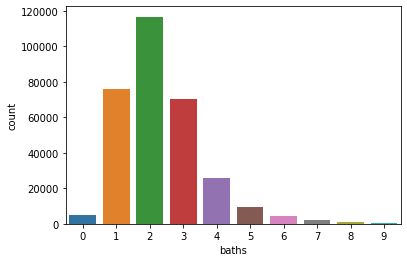

In [6]:
sns.countplot(x='baths',data=data)

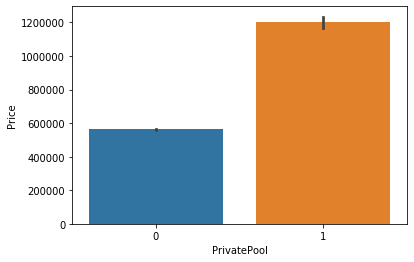

In [7]:
sns.barplot(x='PrivatePool', y='Price', data=data)

In [ ]:
sns.heatmap(Features.corr(), annot=True, cmap='coolwarm')

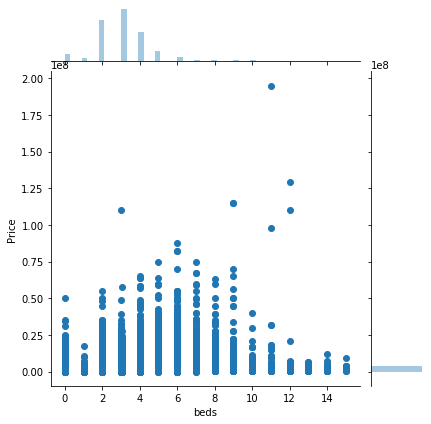

In [35]:
sns.jointplot(x='beds',y='Price',data=data)

In [17]:
Features.beds.value_counts(normalize=True,bins=10)

(-0.145, 14.4]    0.999112
(14.4, 28.8]      0.000722
(28.8, 43.2]      0.000096
(43.2, 57.6]      0.000035
(72.0, 86.4]      0.000013
(57.6, 72.0]      0.000013
(86.4, 100.8]     0.000006
(129.6, 144.0]    0.000003
(115.2, 129.6]    0.000000
(100.8, 115.2]    0.000000
Name: beds, dtype: float64

# Model

In [42]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [37]:
X_train, X_test, y_train, y_test = train_test_split(Features, target, test_size=0.2)
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (249436, 5)
X_test: (62360, 5)
y_train: (249436,)
y_test: (62360,)


In [38]:
predictor = LinearRegression()
predictor.fit(X_train, y_train)
y_pred = predictor.predict(X_test)

In [ ]:
start = timer()
predictor = GradientBoostingRegressor(n_estimators=10000, random_state=42, learning_rate=0.05)
predictor.fit(X_train, y_train)
y_pred = predictor.predict(X_test)
end = timer()
print(end - start)

In [ ]:
print(f'Score: {predictor.score(X_test,y_test)}, MSE: {metrics.r2_score(y_test, y_pred)}')